<a href="https://colab.research.google.com/github/ask350/UM-Projects/blob/main/Fraud%20Detection/fraud_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 1 - import libraries

import gdown, os, glob, joblib, shap, warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    precision_recall_curve, auc
)
import lightgbm as lgb
warnings.filterwarnings("ignore")
plt.style.use("seaborn-v0_8")


In [2]:
# 2 - download data

url = "https://drive.google.com/file/d/1nchGP_dxwA1FKa8N_Ctf2D4eUScaw9do/view?usp=drive_link"
output = "fraud_pkl.zip"
gdown.download(url, output, quiet=False, fuzzy=True)

Downloading...
From (original): https://drive.google.com/uc?id=1nchGP_dxwA1FKa8N_Ctf2D4eUScaw9do
From (redirected): https://drive.google.com/uc?id=1nchGP_dxwA1FKa8N_Ctf2D4eUScaw9do&confirm=t&uuid=32c6b50c-5d76-41f9-9edf-55eb14282817
To: /content/fraud_pkl.zip
100%|██████████| 28.7M/28.7M [00:00<00:00, 80.6MB/s]


'fraud_pkl.zip'

In [3]:
# 3 - unzip data

!unzip -q fraud_pkl.zip -d fraud_pkl

In [4]:
# 4 - combine all .pkl files into one

data_folder = "/content/fraud_pkl/data"


pkl_files = sorted(glob.glob(os.path.join(data_folder, "*.pkl")))
pkl_files = [f for f in pkl_files if "2018-04-01.pkl" <= os.path.basename(f) <= "2018-09-30.pkl"]

dfs = []
for f in tqdm(pkl_files, desc="Combining files"):
    dfs.append(pd.read_pickle(f))

full_df = pd.concat(dfs, ignore_index=True)
print("✅ Combined shape:", full_df.shape)


Combining files: 100%|██████████| 183/183 [00:04<00:00, 40.81it/s]

✅ Combined shape: (1754155, 9)


In [6]:
# 5 - Data Cleaning

full_df['TX_DATETIME'] = pd.to_datetime(full_df['TX_DATETIME'], errors='coerce').ffill()
full_df['CUSTOMER_ID'] = full_df['CUSTOMER_ID'].astype(str)
full_df['TERMINAL_ID'] = full_df['TERMINAL_ID'].astype(str)

num_cols = ['TX_TIME_SECONDS', 'TX_TIME_DAYS', 'TX_AMOUNT', 'TX_FRAUD', 'TX_FRAUD_SCENARIO']
for col in num_cols:
    full_df[col] = pd.to_numeric(full_df[col], errors='coerce').fillna(0)

print(full_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1754155 entries, 0 to 1754154
Data columns (total 9 columns):
 #   Column             Dtype         
---  ------             -----         
 0   TRANSACTION_ID     int64         
 1   TX_DATETIME        datetime64[ns]
 2   CUSTOMER_ID        object        
 3   TERMINAL_ID        object        
 4   TX_AMOUNT          float64       
 5   TX_TIME_SECONDS    int64         
 6   TX_TIME_DAYS       int64         
 7   TX_FRAUD           int64         
 8   TX_FRAUD_SCENARIO  int64         
dtypes: datetime64[ns](1), float64(1), int64(5), object(2)
memory usage: 120.4+ MB
None


In [8]:
# 6 Feature Engg

full_df['hour'] = full_df['TX_DATETIME'].dt.hour.astype(np.int8)
full_df['weekday_code'] = full_df['TX_DATETIME'].dt.weekday.astype(np.int8)
full_df['month_code'] = full_df['TX_DATETIME'].dt.month.astype(np.int8)

print("⏳ Building rolling features (optimized)...")

def add_rolling_features(df, entity_col, windows=[7,14,28]):
    df = df.sort_values(["TX_DATETIME"])
    for w in windows:
        grp = df.groupby(entity_col)
        df[f"{entity_col}_nb_tx_{w}d"] = grp['TX_AMOUNT'].transform(lambda x: x.rolling(w, min_periods=1).count().shift(1).fillna(0))
        df[f"{entity_col}_avg_amt_{w}d"] = grp['TX_AMOUNT'].transform(lambda x: x.rolling(w, min_periods=1).mean().shift(1).fillna(0))
        df[f"{entity_col}_nb_fraud_{w}d"] = grp['TX_FRAUD'].transform(lambda x: x.rolling(w, min_periods=1).sum().shift(1).fillna(0))
    return df

full_df = add_rolling_features(full_df, "CUSTOMER_ID")
full_df = add_rolling_features(full_df, "TERMINAL_ID")
print("✅ Features added:", len(full_df.columns))

⏳ Building rolling features (optimized)...
✅ Features added: 30


Fraud Rate: 0.84%


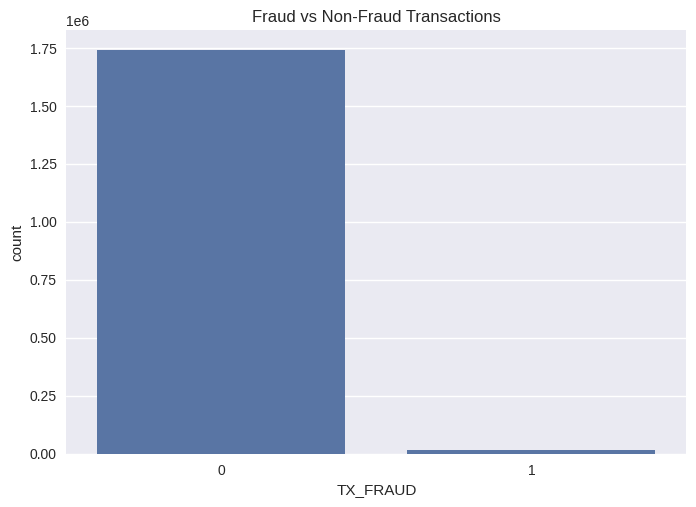

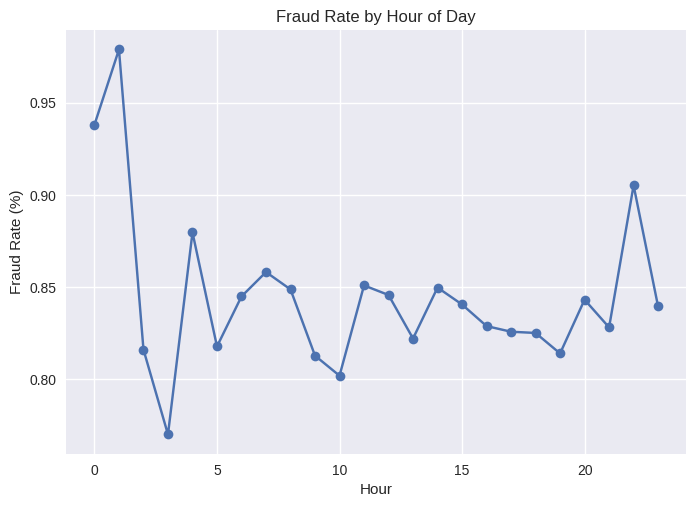

In [9]:
# 7 EDA

fraud_rate = (full_df['TX_FRAUD'].mean() * 100)
print(f"Fraud Rate: {fraud_rate:.2f}%")

sns.countplot(x="TX_FRAUD", data=full_df)
plt.title("Fraud vs Non-Fraud Transactions")
plt.show()

fraud_by_hour = full_df.groupby("hour")["TX_FRAUD"].mean() * 100
plt.plot(fraud_by_hour.index, fraud_by_hour.values, marker="o")
plt.title("Fraud Rate by Hour of Day")
plt.ylabel("Fraud Rate (%)")
plt.xlabel("Hour")
plt.show()



In [10]:
# 8 Train Test Split

train_df = full_df[full_df['TX_DATETIME'] < "2018-09-01"]
test_df  = full_df[full_df['TX_DATETIME'] >= "2018-09-01"]

features = [c for c in full_df.columns if c not in ['TX_FRAUD','TX_DATETIME','CUSTOMER_ID','TERMINAL_ID','TX_FRAUD_SCENARIO']]
X_train, y_train = train_df[features], train_df['TX_FRAUD']
X_test, y_test   = test_df[features], test_df['TX_FRAUD']

print("Train:", X_train.shape, " Test:", X_test.shape)

Train: (1466282, 25)  Test: (287873, 25)


In [11]:
# 9 - Feature Scaling (LogReg Only)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


=== Logistic Regression ===
              precision    recall  f1-score   support

           0     0.9996    0.9751    0.9872    285326
           1     0.2547    0.9517    0.4018      2547

    accuracy                         0.9749    287873
   macro avg     0.6271    0.9634    0.6945    287873
weighted avg     0.9930    0.9749    0.9820    287873

ROC AUC: 0.9831608922524926
PR AUC: 0.8644363374211459


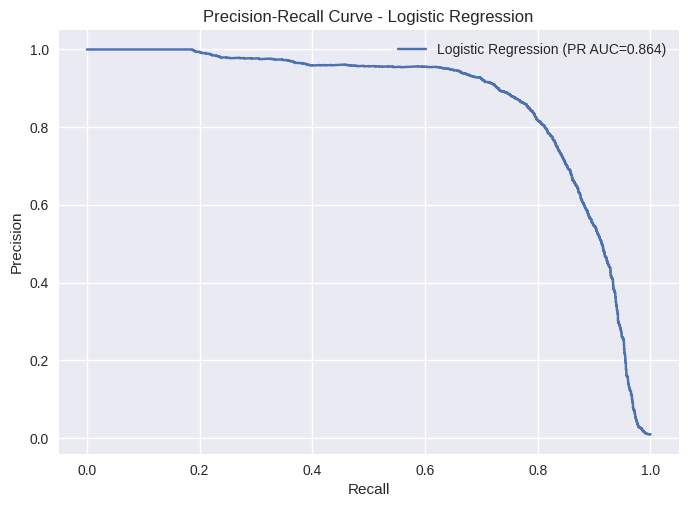

In [12]:
# 10 - Models

def evaluate_model(name, y_test, y_pred, y_proba):
    print(f"\n=== {name} ===")
    print(classification_report(y_test, y_pred, digits=4))
    print("ROC AUC:", roc_auc_score(y_test, y_proba))
    prec, rec, _ = precision_recall_curve(y_test, y_proba)
    pr_auc = auc(rec, prec)
    print("PR AUC:", pr_auc)
    plt.plot(rec, prec, label=f"{name} (PR AUC={pr_auc:.3f})")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.legend()
    plt.title(f"Precision-Recall Curve - {name}")
    plt.show()


#  Logistic Regression

log_reg = LogisticRegression(max_iter=1000, class_weight="balanced", n_jobs=-1)
log_reg.fit(X_train_scaled, y_train)
evaluate_model("Logistic Regression", y_test, log_reg.predict(X_test_scaled), log_reg.predict_proba(X_test_scaled)[:,1])



=== Random Forest ===
              precision    recall  f1-score   support

           0     0.9994    0.9882    0.9938    285326
           1     0.4141    0.9348    0.5739      2547

    accuracy                         0.9877    287873
   macro avg     0.7067    0.9615    0.7839    287873
weighted avg     0.9942    0.9877    0.9901    287873

ROC AUC: 0.9842737597631144
PR AUC: 0.8656159364757118


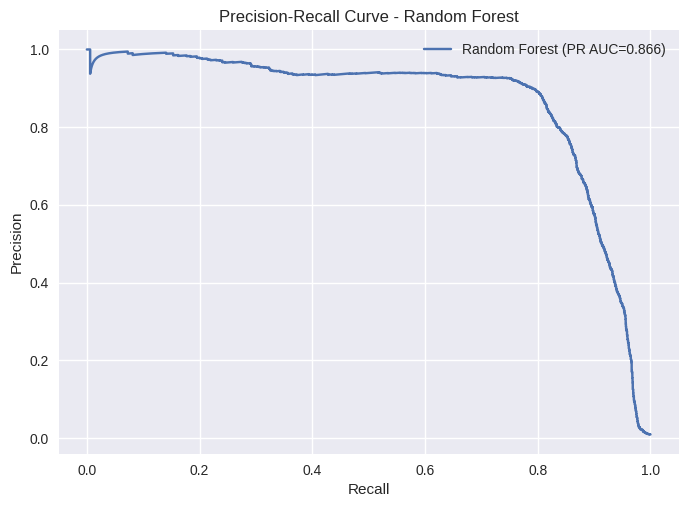

In [13]:
# 10 - Random Forest

rf = RandomForestClassifier(n_estimators=200, max_depth=10, class_weight="balanced", random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
evaluate_model("Random Forest", y_test, rf.predict(X_test), rf.predict_proba(X_test)[:,1])

[LightGBM] [Info] Number of positive: 12134, number of negative: 1454148
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.406679 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2676
[LightGBM] [Info] Number of data points in the train set: 1466282, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008275 -> initscore=-4.786164
[LightGBM] [Info] Start training from score -4.786164

=== LightGBM ===
              precision    recall  f1-score   support

           0     0.9995    0.9866    0.9930    285326
           1     0.3873    0.9482    0.5499      2547

    accuracy                         0.9863    287873
   macro avg     0.6934    0.9674    0.7715    287873
weighted avg     0.9941    0.9863    0.9891    287873

ROC AUC: 0.9856260774411271
PR AUC: 0.913224478290892


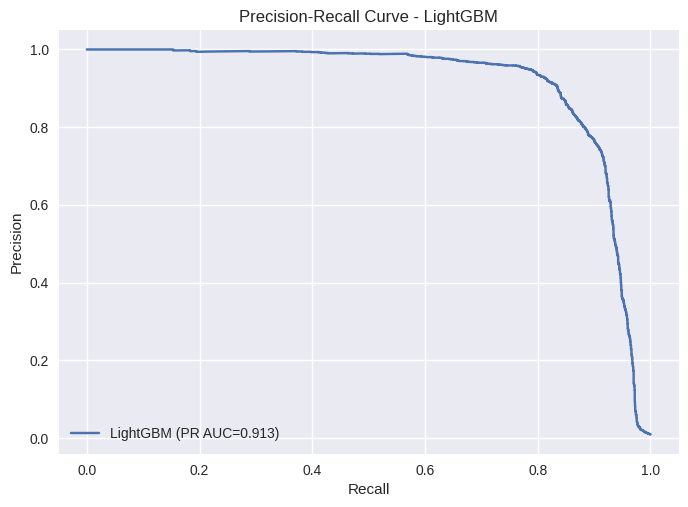

In [14]:
# 10 - LightGBM

lgbm = lgb.LGBMClassifier(n_estimators=300, learning_rate=0.05,
                          scale_pos_weight=(len(y_train)-sum(y_train))/sum(y_train),
                          random_state=42, n_jobs=-1)
lgbm.fit(X_train, y_train)
evaluate_model("LightGBM", y_test, lgbm.predict(X_test), lgbm.predict_proba(X_test)[:,1])

In [ ]:
# 10 - Hyperparameter Tuning (Random Forest example) - computationally expensive
"""
param_grid = {'n_estimators':[200,300],'max_depth':[8,10,12],'min_samples_split':[2,5]}
grid = GridSearchCV(rf, param_grid, scoring='recall', cv=3, n_jobs=-1)
grid.fit(X_train, y_train)
print("Best Params (RF):", grid.best_params_)
"""

🔍 Running fast randomized search for Random Forest...
Fitting 3 folds for each of 8 candidates, totalling 24 fits

✅ Best Parameters (RF): {'max_depth': 6, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 208}

=== Random Forest (Tuned) ===
              precision    recall  f1-score   support

           0     0.9995    0.9787    0.9890    285326
           1     0.2834    0.9435    0.4359      2547

    accuracy                         0.9784    287873
   macro avg     0.6415    0.9611    0.7125    287873
weighted avg     0.9931    0.9784    0.9841    287873

ROC AUC: 0.9810720762252453
PR AUC: 0.8028461305849792


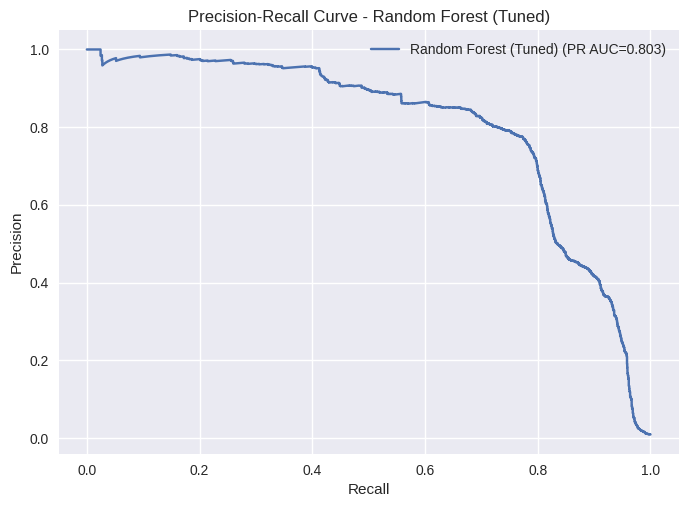

In [17]:
# 10 - Fast Hyperparameter Tuning (RandomizedSearchCV)

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

print("🔍 Running fast randomized search for Random Forest...")

# Define parameter distributions
param_dist = {
    'n_estimators': randint(150, 400),
    'max_depth': randint(6, 12),
    'min_samples_split': randint(2, 6),
    'min_samples_leaf': randint(1, 4)
}

# Use smaller subset for speed
sample_frac = 0.15   # 15% of training data
X_sample = X_train.sample(frac=sample_frac, random_state=42)
y_sample = y_train.loc[X_sample.index]

rf_tuned = RandomForestClassifier(class_weight="balanced", random_state=42, n_jobs=-1)

# Randomized search setup
rand_search = RandomizedSearchCV(
    rf_tuned,
    param_distributions=param_dist,
    n_iter=8,                # only 8 random combinations
    scoring='recall',        # recall is important in fraud detection
    cv=3,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

rand_search.fit(X_sample, y_sample)
print("\n Best Parameters (RF):", rand_search.best_params_)

# Train RF with best params on full training data
rf_best = rand_search.best_estimator_
rf_best.fit(X_train, y_train)

# Evaluate tuned RF
evaluate_model("Random Forest (Tuned)", y_test, rf_best.predict(X_test), rf_best.predict_proba(X_test)[:,1])


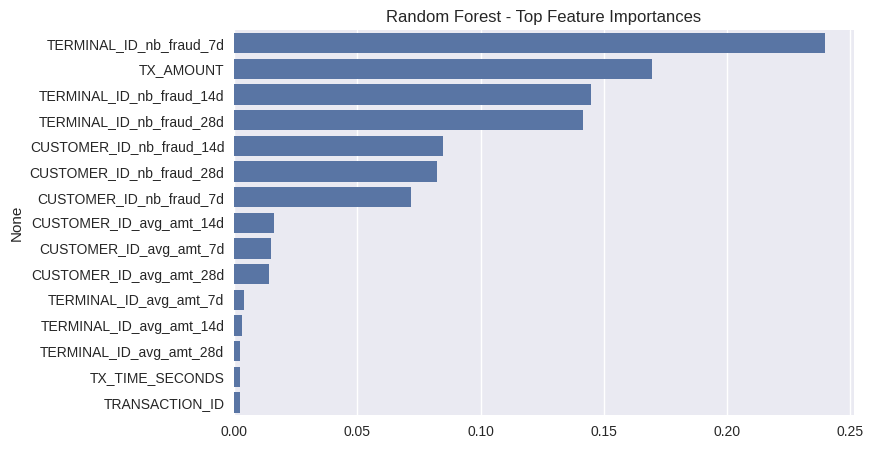

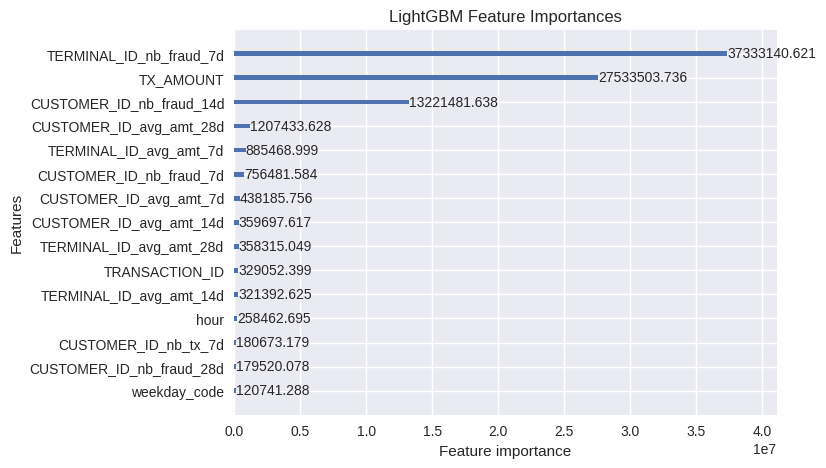

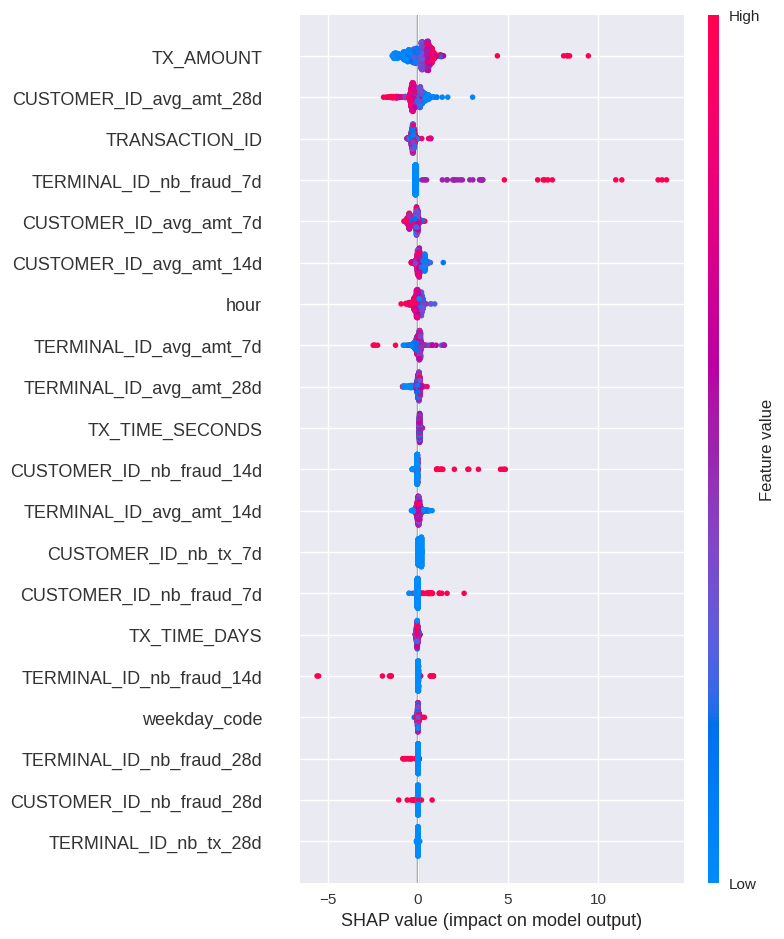

In [18]:
# 11 - Feature Importance & Explainability

rf_importances = pd.Series(rf.feature_importances_, index=features).sort_values(ascending=False).head(15)
plt.figure(figsize=(8,5))
sns.barplot(x=rf_importances.values, y=rf_importances.index)
plt.title("Random Forest - Top Feature Importances")
plt.show()

lgb.plot_importance(lgbm, max_num_features=15, importance_type='gain', figsize=(7,5))
plt.title("LightGBM Feature Importances")
plt.show()

explainer = shap.TreeExplainer(lgbm)
shap_values = explainer.shap_values(X_test.sample(1000, random_state=42))
shap.summary_plot(shap_values, X_test.sample(1000, random_state=42))

In [19]:
# 12 - Save Model & Threshold Optimization

joblib.dump(lgbm, "fraud_detection_model.pkl")
print("Model saved")

prec, rec, thr = precision_recall_curve(y_test, lgbm.predict_proba(X_test)[:,1])
f1 = 2*(prec*rec)/(prec+rec)
best_idx = np.argmax(f1)
print(f"Best Threshold: {thr[best_idx]:.3f}, F1: {f1[best_idx]:.3f}")

Model saved
Best Threshold: 0.981, F1: 0.869
